In [65]:
# Define model MLP Model
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
device = 'cpu'
# Define your binary classification model
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_size = 17 * 2, hidden_size = 20, output_size = 1):
        super(MLPBinaryClassifier, self).__init__()
        # self.fc1 = nn.Linear(input_size, hidden_size)
        # self.relu = nn.ReLU()
        # self.fc2 = nn.Linear(hidden_size, output_size)
        # self.sigmoid = nn.Sigmoid()
        self.model = nn.Sequential(
                            nn.Linear(input_size, hidden_size),
                            nn.ReLU(),
                            nn.Linear(hidden_size, hidden_size),
                            nn.ReLU(),
                            nn.Linear(hidden_size, 1),
                            nn.Sigmoid())

    def forward(self, x):
        # x,c = x
        n = x.size(0)
        x = x.view(n,-1)
        
        out = self.model(x)
        return out

# Initialize the model, loss function, and optimizer
input_dim = 17 * 2 # x,y keypoints
hidden_size = 20
mlp_model = MLPBinaryClassifier(input_dim, hidden_size = hidden_size ).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

mlp_model.load_state_dict(torch.load('trained_model.pth'))

<All keys matched successfully>

In [149]:
# Define Fall Detection Model
from ultralytics import YOLO
import os
import json_tricks as json
import matplotlib.pyplot as plt
import cv2

yolo_pose = YOLO('yolov8n-pose.pt')  # load an official model

# Define your binary classification model
class FallDetection(nn.Module):
    def __init__(self, mlp, pose, device):
        super(FallDetection, self).__init__()
        # self.fc1 = nn.Linear(input_size, hidden_size)
        # self.relu = nn.ReLU()
        # self.fc2 = nn.Linear(hidden_size, output_size)
        # self.sigmoid = nn.Sigmoid()
        self.device = device
        self.mlp = mlp
        self.pose = pose

    def forward(self, x):
        # x,c = x        
        out = self.pose(x, device = self.device, verbose = False)      
        outs = []  
        for res in out:
            # box  = res.boxes
            kpts = res.keypoints                
            if kpts.has_visible:
                indx = torch.argmax( res.boxes.conf)
                kpts = kpts.xyn[indx].reshape(-1)
                
            else:
                # print(len(out))
                kpts = torch.zeros((17*2), device= device)
            outs.append(kpts)
        outs = torch.stack(outs, dim = 0)        
        return model.mlp(outs)

    def predict_all_instances(self, x):
        # x,c = x        
        results = {'pred' : [], 
                   'conf' : [],
                   'boxs': [],
                   'keys' : []}
        out = self.pose(x, device = self.device, verbose = False)                      
        for res in out:
            # box  = res.boxes
            box  = res.boxes
            kpts = res.keypoints                
            if kpts.has_visible:                
                kpts = kpts.xyn.reshape((-1,17*2))      
                xyxy = box.xyxy 
                conf = box.conf    
            else:
                # print(len(out))
                kpts = torch.zeros((1,17*2), device= device)
                xyxy = torch.zeros((1,4), device= device)
                conf = 0
            results['pred'].append(model.mlp(kpts))    
            results['boxs'].append(xyxy)
            results['keys'].append(kpts)
            results['conf'].append(conf)
        return results

    

img_paths = ['test1.jpg', 'test2.jpg']
model = FallDetection(mlp_model, yolo_pose, device=device)
# outs = model(img_path)
# out = model.predict_all_instances(img_paths)

[     0.9251]
[  0.0020382]


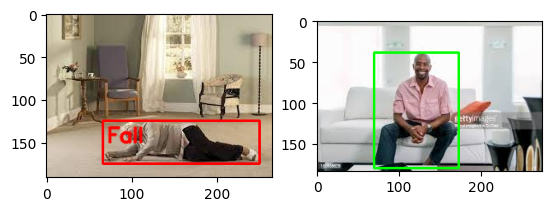

In [163]:
imgs = []
for path in img_paths:
    img = np.array( plt.imread(path))
    out = model.predict_all_instances(path)
    for i in range(len(out['pred'][0])):
        boxs = out['boxs'][0].cpu().detach().numpy()[i].astype(np.int32)
        pred = out['pred'][0].cpu().detach().numpy()[i]
        keys = out['keys'][0].cpu().detach().numpy()[i]
        conf = out['conf'][0].cpu().detach().numpy()[i]
        print(pred)
        if pred > 0.5:
            img = cv2.rectangle(img, boxs[:2], boxs[2:], (255,0,0), 2)
            img = cv2.putText  (img, 'Fall', (boxs[0]+5, boxs[1] + 25), cv2.FONT_HERSHEY_SIMPLEX ,  0.8, (255,0,0), 2, cv2.LINE_AA)
        else:
            img = cv2.rectangle(img, boxs[:2], boxs[2:], (0,255,0), 2)
    imgs.append(img)

fig, ax = plt.subplots(1,2)
ax[0].imshow(imgs[0])
ax[1].imshow(imgs[1])


In [96]:
"""
Training MLP Model
Here model is mlp model, and train_loader and test_loader contains xyn data and predictions 1 for fall and 0 for not fall.
"""
# # Training loop
# n_epochs = 500
# losslog = {'loss' :[], 'train_acc' : [], 'val_acc':[]}
# def train_model(model, n_epochs = 100, train_loader, test):
#     for epoch in range(n_epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, labels in train_loader:        
#             outputs = model(inputs)        
#             loss = criterion(outputs.squeeze(), labels)
#             optimizer.zero_grad()        
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item() * labels.size(0)
#         epoch_loss = running_loss / len(train_loader.dataset)
#         # if (epoch+1) % 50 == 0:        
#         # Evaluation
#         model.eval()
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for inputs, labels in train_loader:
#                 outputs = model(inputs)
#                 outputs = outputs.squeeze()
#                 predicted = (outputs >= 0.5).float()
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         train_accuracy = correct / total
#         # print(correct, total)
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for inputs, labels in test_loader:
#                 outputs = model(inputs)
#                 outputs = outputs.squeeze()
#                 predicted = (outputs >= 0.5).float()
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()
#         # print(correct, total)
#         val_accuracy = correct / total
#         if (epoch+1) % 50 == 0:        
#             print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}",  f"Train Accuracy: {train_accuracy:.4f}",f"Test Accuracy: {val_accuracy:.4f}")
#         losslog['loss'].append(epoch_loss)
#         losslog['train_acc'].append(train_accuracy)
#         losslog['val_acc'].append(val_accuracy)
#     return model, losslog

'\nTraining MLP Model\nHere model is mlp model, and train_loader and test_loader contains xyn data and predictions 1 for fall and 0 for not fall.\nTrain.json contains data\n'